# Importing Libraries

In [1]:
import nbimporter  # Notebook importer: enables importing modules defined in Jupyter notebooks—useful for structuring analysis pipelines interactively.
from Step1_processing import red_tags_extracted  # Import custom red‐tag detection function from your Step1_processing module.

import numpy as np  
import pandas as pd  

from skimage import io, color, measure, img_as_ubyte, morphology  
from skimage.io import imread  
from skimage.draw import polygon, line  
from skimage.measure import label, regionprops  
from skimage.morphology import (
    square, disk,             
    closing, opening,          
    erosion, binary_dilation,   
    remove_small_objects        
)

from skimage import exposure, filters  
from skimage.util import img_as_ubyte 
import cv2  
from ultralytics import YOLO  # Ultralytics YOLO: state‐of‐the‐art object detection framework,.
import matplotlib.pyplot as plt  
from matplotlib import patches  
from PIL import Image  
import os  
from scipy.spatial.distance import euclidean, cdist  

#  Spike position extraction was based on YOLOv8-WFD model

In [2]:
def classification_sipke(image_path, results):
    # 1. Load original image as an RGB NumPy array
    original_image = imread(image_path)
    
    # 2. Extract class name mapping and detected boxes from the first result
    names = results[0].names          
    boxes = results[0].boxes         
    # 3. Count occurrences of each detected class
    class_counts = {}
    for box in boxes:
        # Retrieve the predicted class ID as an integer
        cls_id = int(box.cls.cpu().numpy()[0])
        class_name = names.get(cls_id)
        if class_name:
            # Increment count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
    # 4. Specifically extract counts for "scab" and "spike"
    Scab = class_counts.get("scab", 0)
    Spike = class_counts.get("spike", 0)
    Spikes = Scab + Spike  # total symptom instances detected

    # 5. Retrieve raw bounding box coordinates and labels
    #    xyxy format: [x1, y1, x2, y2] for each box
    label_site = boxes.xyxy.tolist()
    labels = [int(i) for i in boxes.cls.tolist()]
    # Pair each box with its class label
    label_site_spike_sets = list(zip(label_site, labels))

    # 6. Generate a combined segmentation mask over all detected instances
    #    and apply it to the original image to isolate symptomatic regions
    image_spike_masks = np.zeros_like(original_image)  # initialize output image
    for result in results:
        # result.masks.xy is a list of polygons for each detected instance
        for poly_coords in result.masks.xy:
            # Ensure the polygon has at least 3 vertices
            if len(poly_coords) >= 3:
                # poly_coords is an (N,2) array of (x, y) points
                rr, cc = polygon(poly_coords[:, 1], poly_coords[:, 0],
                                 shape=original_image.shape)
                # Copy the original pixel values into the mask region
                image_spike_masks[rr, cc, :] = original_image[rr, cc, :]

    return Spikes, Scab, label_site_spike_sets, image_spike_masks


In [3]:
def Coordinate_filtering(label_site_spike_sets, bbox_red_sets, number):
    # 1. Initialize list to store final tag–spike pairings
    paired_coordinates = []
    # 2. Ensure 'number' is an integer for distance-based selection
    number = int(number)

    # 3. Iterate over each red tag bounding box
    for red_bbox in bbox_red_sets:
        # 3a. If there are fewer detections than requested, stop pairing
        if len(label_site_spike_sets) < number:
            break

        # 3b. Compute the geometric center of the red tag bbox: (x_center, y_center)
        red_center = [
            (red_bbox[0] + red_bbox[2]) / 2,  # x_center = (x1 + x2) / 2
            (red_bbox[1] + red_bbox[3]) / 2   # y_center = (y1 + y2) / 2
        ]

        # 4. Compute distances from this red tag to all symptom detections
        distances = []
        for label_bbox, label in label_site_spike_sets:
            # 4a. Compute the center of the symptom bbox
            label_center = [
                (label_bbox[0] + label_bbox[2]) / 2,
                (label_bbox[1] + label_bbox[3]) / 2
            ]
            # 4b. Euclidean distance between centers
            dist = euclidean(red_center, label_center)
            distances.append((dist, label_bbox, label_center, label))

        # 5. Sort detections by ascending distance and pick the N closest
        distances.sort(key=lambda x: x[0])
        closest = distances[:number]

        # 6. Assign each closest detection to the current red tag if not already paired
        for _, label_bbox, _, label in closest:
            if (label_bbox, label) not in paired_coordinates:
                paired_coordinates.append((label_bbox, label))

    # 7. Return the list of paired (bbox, class_id) tuples
    return paired_coordinates



In [4]:
def disease_spikes_mask_WFD(image, results):
    # Container for processed ROI images
    roi_image_masks_WFD = []
    
    # Retrieve all detected bounding boxes and mask objects
    boxes = results[0].boxes      
    masks = results[0].masks      
    
    # Iterate through each detection (box, mask pair)
    for box, mask in zip(boxes, masks):
        # 1. Only process class 0 (green areas marking regions of interest)
        cls_id = int(box.cls.cpu().numpy()[0])
        if cls_id != 0:
            continue
        
        # 2. Extract and sanitize bounding box coordinates
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
        x1, y1 = max(0, x1), max(0, y1)
        x2 = min(image.shape[1], x2)
        y2 = min(image.shape[0], y2)
        
        # 3. Crop the ROI images from the original image
        roi = image[y1:y2, x1:x2]
        # Convert to 8‑bit unsigned integers for consistent processing
        roi = img_as_ubyte(roi)
        
        # 4. Convert to grayscale and binarize
        #    Here, any non‑zero pixel becomes foreground
        gray = color.rgb2gray(roi)
        binary = gray > 0
        
        # 5. Label connected components in the binary ROI
        labeled = label(binary)
        regions = regionprops(labeled)
        
        if regions:
            # 6. Select the largest connected component by area
            largest = max(regions, key=lambda r: r.area)
            mask_largest = (labeled == largest.label)
            
            # 7. Create an output image containing only the largest component
            filtered = np.zeros_like(roi)
            filtered[mask_largest] = roi[mask_largest]
            roi_image_masks_WFD.append(filtered)
        else:
            # 8. If no components found, fall back to the unfiltered ROI
            roi_image_masks_WFD.append(roi)
    
    return roi_image_masks_WFD


In [5]:
def spike_mask_acquisition(paired_coordinates, image_spike_masks, image_path):
    # List to collect cropped images of diseased spikes
    image_scab = []
    # List to collect coordinates of crops labeled as diseased
    disease_spike = []
    # If no pairings exist, proportion is zero and no crops to process
    if not paired_coordinates:
        Pct_of_diseased_spikes_region = 0.0
        return [], Pct_of_diseased_spikes_region
    
    # Load the original image for coordinate bounds checking
    original_image = imread(image_path)
    
    # Iterate through each red‐tag/spike pairing
    for bbox_pair, label_id in paired_coordinates:
        # Parse and clamp bounding box coordinates to image dimensions
        x1, y1, x2, y2 = map(int, map(float, bbox_pair[:4]))
        y1 = max(0, y1)
        y2 = min(original_image.shape[0], y2)
        x1 = max(0, x1)
        x2 = min(original_image.shape[1], x2)
        
        # Crop the corresponding region from the precomputed spike mask image
        roi_masked = image_spike_masks[y1:y2, x1:x2]
        # Ensure 8‐bit format for subsequent processing
        roi_masked = img_as_ubyte(roi_masked)
        
        # Convert to grayscale and binarize: nonzero pixels indicate masked spike area
        gray = color.rgb2gray(roi_masked)
        binary = gray > 0
        
        # Label connected components to isolate contiguous diseased tissue
        labeled = label(binary)
        regions = regionprops(labeled)
        
        if regions:
            # Retain only the largest connected component (dominant diseased region)
            largest = max(regions, key=lambda r: r.area)
            mask_largest = (labeled == largest.label)
            
            # Build an output crop showing only that region
            filtered = np.zeros_like(roi_masked)
            filtered[mask_largest] = roi_masked[mask_largest]
            image_scab.append(filtered)
        else:
            # Fallback: if no region found, keep the raw masked crop
            image_scab.append(roi_masked)
        
        # Record this bbox as diseased if its label_id == 0
        if label_id == 0:
            disease_spike.append(bbox_pair)
    
    # Compute fraction of pairings labeled as diseased
    Pct_of_diseased_spikes_region = len(disease_spike) / len(paired_coordinates)
    
    return image_scab, Pct_of_diseased_spikes_region


In [6]:
def calculate_percentage_area_AExG(image):
    # 1. Initial binary mask: identify any non-black pixels in the grayscale image
    gray = color.rgb2gray(image)
    binary_initial = gray > 0

    # 2. Morphological erosion to remove boundary artifacts
    #    Use a structuring element radius equal to 5% of the smaller image dimension
    h, w = binary_initial.shape
    radius = int(min(h, w) * 0.05)
    if radius > 0:
        binary_eroded = erosion(binary_initial, disk(radius))
    else:
        binary_eroded = binary_initial

    # 3. Label connected components and select the largest as the primary spike region
    labeled_spikes = measure.label(binary_eroded)
    spike_props = measure.regionprops(labeled_spikes)
    if not spike_props:
        return 0.0, None, None

    # Find and mask the largest connected component
    largest_spike = max(spike_props, key=lambda p: p.area)
    spike_mask = (labeled_spikes == largest_spike.label)

    # 4. Compute the Excess Green (ExG) index within the primary spike region
    #    ExG = 2*G - R - B highlights vegetation relative to other colors
    masked_rgb = image.copy()
    masked_rgb[~spike_mask] = 0  # zero out pixels outside the spike region
    R = masked_rgb[:, :, 0].astype(float)
    G = masked_rgb[:, :, 1].astype(float)
    B = masked_rgb[:, :, 2].astype(float)
    ExG = 2 * G - R - B

    # 5. Normalize ExG to [0, 1] for thresholding
    ExG_norm = exposure.rescale_intensity(ExG, in_range=(-255, 255), out_range=(0, 1))

    # 6. Segment green vegetation using a fixed threshold (tunable)
    #    Here, 0.6 is chosen empirically; adjust as needed for lighting conditions
    thresh = 0.6
    green_mask = ExG_norm > thresh

    # 7. Remove small spurious regions (noise) smaller than 1% of image area
    min_region_size = int(h * w * 0.01)
    green_mask = remove_small_objects(green_mask, min_size=min_region_size)

    # 8. Identify non-green (scab/diseased) areas within the primary spike region
    non_green_mask = spike_mask & ~green_mask
    non_green_mask = remove_small_objects(non_green_mask, min_size=min_region_size)

    # 9. Label non-green components and select the largest as the scab region
    labeled_non_green = measure.label(non_green_mask)
    non_green_props = measure.regionprops(labeled_non_green)
    if not non_green_props:
        return 0.0, None, spike_mask

    largest_scab = max(non_green_props, key=lambda p: p.area)
    scab_mask = (labeled_non_green == largest_scab.label)

    # 10. Compute area ratio: scab area / total spike area
    spike_area = spike_mask.sum()
    scab_area = scab_mask.sum()
    scab_area_ratio = scab_area / spike_area if spike_area > 0 else 0.0

    return scab_area_ratio, scab_mask, spike_mask



In [7]:
def adjust_line_position(rr, cc, max_region_polygon_on_opened):

    # If less than 80% of the line lies within the target region, reposition the line.
    if np.sum(max_region_polygon_on_opened[rr, cc] == 1) < len(rr) * 0.8:
        # Calculate the centroid of the target region.
        center_y, center_x = np.mean(np.argwhere(max_region_polygon_on_opened == 1), axis=0)
        
        # Compute the shift needed to move the line's center towards the region's centroid.
        line_y_shift = np.mean(rr) - center_y
        line_x_shift = np.mean(cc) - center_x
        
        # Apply the shift to the line's coordinates.
        rr_adjusted = rr - int(line_y_shift)
        cc_adjusted = cc - int(line_x_shift)
        
        # Ensure that the new coordinates remain within valid image boundaries.
        rr_adjusted = np.clip(rr_adjusted, 0, max_region_polygon_on_opened.shape[0] - 1)
        cc_adjusted = np.clip(cc_adjusted, 0, max_region_polygon_on_opened.shape[1] - 1)
        
        return rr_adjusted, cc_adjusted
    else:
        # If the overlap is sufficient, retain the original line coordinates.
        return rr, cc


def Calculate_the_length_percentage(binary_img, max_region_polygon_on_opened):

    # Return 0 if either input is invalid.
    if max_region_polygon_on_opened is None or binary_img is None:
        return 0  

    # Label connected regions within the binary image.
    label_image = measure.label(binary_img)
    props = measure.regionprops(label_image)
    
    # Identify the largest region based on area.
    max_area_idx = np.argmax([prop.area for prop in props])
    coords = props[max_area_idx].coords

    # Extract characteristic boundary points in multiple directions.
    top_coords = coords[0]
    bottom_coords = coords[-1]
    left_bottom_coords = min(coords, key=lambda x: x[0] + x[1])
    right_top_coords = max(coords, key=lambda x: x[0] + x[1])
    left_top_coords = min(coords, key=lambda x: x[0] - x[1])
    right_bottom_coords = max(coords, key=lambda x: x[0] - x[1])
    
    # Calculate Euclidean distances between pairs of characteristic points.
    distances = [
        np.linalg.norm(np.array(top_coords) - np.array(bottom_coords)),
        np.linalg.norm(np.array(left_bottom_coords) - np.array(right_top_coords)),
        np.linalg.norm(np.array(left_top_coords) - np.array(right_bottom_coords))
    ]
    
    # Determine the direction along which the maximum length occurs.
    max_distance_idx = np.argmax(distances)
    rr, cc = None, None
    
    # Generate line coordinates corresponding to the maximum length direction.
    if max_distance_idx == 0:
        rr, cc = line(top_coords[0], top_coords[1], bottom_coords[0], bottom_coords[1])
    elif max_distance_idx == 1:
        rr, cc = line(left_bottom_coords[0], left_bottom_coords[1], right_top_coords[0], right_top_coords[1])
    else:
        rr, cc = line(left_top_coords[0], left_top_coords[1], right_bottom_coords[0], right_bottom_coords[1])
    
    # Refine the line's position to better align with the target region.
    rr_adjusted, cc_adjusted = adjust_line_position(rr, cc, max_region_polygon_on_opened)
    
    # Compute the proportion of the line that lies within the target region.
    total_line_length = len(rr)
    count_in_region = np.sum(max_region_polygon_on_opened[rr_adjusted, cc_adjusted] == 1)
    length_ratio = count_in_region / total_line_length if total_line_length != 0 else 0
    
    return length_ratio


In [8]:
def plt_diseased_spikes(diseased_spike_image_Yolov8):
    # Calculate the width of each image and sort them in descending order
    image_widths = [img.shape[1] for img in diseased_spike_image_Yolov8]  # Get the width of each image
    sorted_indices = np.argsort(image_widths)[::1]  # Get the indices that sort the widths in descending order

    # Rearrange the images based on the sorted indices
    sorted_images = [diseased_spike_image_Yolov8[i] for i in sorted_indices]

    # Calculate the required number of rows and columns for the plot
    num_rows = len(sorted_images) // 5 + (1 if len(sorted_images) % 5 != 0 else 0)  # Calculate the number of rows
    num_cols = min(len(sorted_images), 20)  # The number of columns is at most 10

    # Set the figure size for the plot
    plt.figure(figsize=(num_cols, num_rows))

    # Display each image in a subplot
    for i in range(len(sorted_images)):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(sorted_images[i])  # Display the image
        plt.axis('off')  # Hide the axes for a cleaner view

    # Show the plot with all images
    plt.show()

# With of red tags

In [9]:
def trait_output_red_tags(image_path, model):
    results = model.predict(image_path, conf=0.5, save=False, show=False, show_labels=False)
    # Extract bounding boxes of red tags (reference markers for diseased spikes)
    bbox_red_sets, image_display = red_tags_extracted(image_path)

    # Classify detected objects (spikes & scab regions)
    Spikes, Scab, label_site_spike_sets, image_spike_masks = classification_sipke(image_path, results)

    # FHB-related traits
    SxSpkPct_Plot = Scab / len(bbox_red_sets)

    # Perform spatial matching between detected spikes and red tags (coordinate pairing)
    paired_coordinates = Coordinate_filtering(label_site_spike_sets, bbox_red_sets, number=4)

    # Obtain binary masks of disease regions (WFD: Whole Field Detection)
    roi_image_masks_WFD = disease_spikes_mask_WFD(image_spike_masks, results)

    # Extract ROI images based on paired coordinates and spike masks
    image_scab, SxSpkPct_ROI = spike_mask_acquisition(paired_coordinates, image_spike_masks, image_path)

    # Initialize lists to store area and length ratios of diseased spikes detected by YOLOv8
    diseased_spike_image_Yolov8_Area_ratio, diseased_spike_image_Yolov8_Length_ratio = [], []

    if roi_image_masks_WFD:
        # Calculate area and length ratios for each diseased spike mask detected by YOLOv8
        for i in roi_image_masks_WFD:
            Area_ratio, max_region_polygon_on_opened, binary_img = calculate_percentage_area_AExG(i)
            Length_ratio = Calculate_the_length_percentage(binary_img, max_region_polygon_on_opened)
            diseased_spike_image_Yolov8_Area_ratio.append(Area_ratio)
            diseased_spike_image_Yolov8_Length_ratio.append(Length_ratio)

        # FHB-related traits
        AvgSxArea_Spk = np.mean(diseased_spike_image_Yolov8_Area_ratio)
        AvgSxLen_Spk = np.mean(diseased_spike_image_Yolov8_Length_ratio)

    # Initialize lists to store area and length ratios within the ROI (paired red tags)
    T_Area_ratio, T_Length_ratio = [], []

    # Calculate area and length ratios for scab regions extracted from ROI
    for i in image_scab:
        Area_ratio, max_region_polygon_on_opened, binary_img = calculate_percentage_area_AExG(i)
        Length_ratio = Calculate_the_length_percentage(binary_img, max_region_polygon_on_opened)
        T_Area_ratio.append(Area_ratio)
        T_Length_ratio.append(Length_ratio)

    # FHB-related traits
    CumSxArea_ROI = np.sum(T_Area_ratio)
    CumSxLen_ROI = np.sum(T_Length_ratio)

    # Return multiple phenotypic indicators and intermediate results
    return SxSpkPct_Plot, SxSpkPct_ROI, CumSxArea_ROI, AvgSxArea_Spk, CumSxLen_ROI, AvgSxLen_Spk, image_scab, results




image 1/1 E:\Evaluation platform-wheat FHB\Data\2.jpg: 640x352 5 scabs, 65 spikes, 149.7ms
Speed: 2.3ms preprocess, 149.7ms inference, 77.7ms postprocess per image at shape (1, 3, 640, 352)


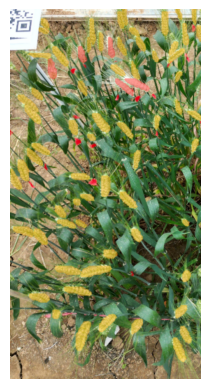

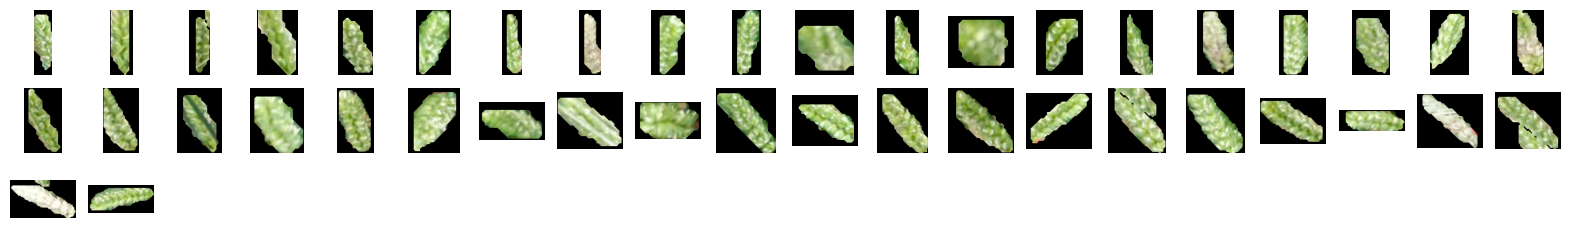

In [10]:
# Load the YOLOv8-WFD model
model = YOLO("Model_save/Yolov8-WFD.pt")
# Path to the input image
image_path = "Data/2.jpg"

# Extract FHB-related traits
_, _, _, _, _, _, image_scab, results = trait_output_red_tags(image_path, model)

# Visualize results 
for r in results:
    im_array = r.plot(conf=0.5, labels=False, boxes=False)
    
    predict_image = Image.fromarray(im_array[..., ::-1])
    
    # Display the prediction result
    plt.axis("off")
    plt.imshow(predict_image)

# Visualize extracted diseased spike regions (scab areas) in grid layout
plt_diseased_spikes(image_scab)


#  Without of red tags

In [11]:
def trait_output_without_red_tags(image_path, model):

    results = model.predict(image_path, conf=0.5, save=False, show=False, show_labels=False)

    # Spike & Scab classification based on detection results
    Spikes, Scab, label_site_spike_sets, image_spike_masks = classification_sipke(image_path, results)

    # Ratio of diseased spikes (scab/spike)
    SxSpkratio_Plot = Scab / Spikes if Spikes != 0 else 0  # Avoid divide by zero

    # Extract disease masks (ROI) of each detected spike
    roi_image_masks_WFD = disease_spikes_mask_WFD(image_spike_masks, results)

    # Initialize area and length ratio lists
    diseased_spike_image_Yolov8_Area_ratio, diseased_spike_image_Yolov8_Length_ratio = [], []

    if roi_image_masks_WFD:
        for mask in roi_image_masks_WFD:
            Area_ratio, max_region_polygon_on_opened, binary_img = calculate_percentage_area_AExG(mask)
            Length_ratio = Calculate_the_length_percentage(binary_img, max_region_polygon_on_opened)

            diseased_spike_image_Yolov8_Area_ratio.append(Area_ratio)
            diseased_spike_image_Yolov8_Length_ratio.append(Length_ratio)

        # Average values across all diseased spikes
        AvgSxArea_Spk = np.mean(diseased_spike_image_Yolov8_Area_ratio)
        AvgSxLen_Spk = np.mean(diseased_spike_image_Yolov8_Length_ratio)

        # Cumulative values across all diseased spikes
        CumSxArea_ROI = np.sum(diseased_spike_image_Yolov8_Area_ratio)
        CumSxLen_ROI = np.sum(diseased_spike_image_Yolov8_Length_ratio)
    else:
        AvgSxArea_Spk, AvgSxLen_Spk, CumSxArea_ROI, CumSxLen_ROI = 0, 0, 0, 0

    return SxSpkratio_Plot, CumSxArea_ROI, AvgSxArea_Spk, CumSxLen_ROI, AvgSxLen_Spk, roi_image_masks_WFD, results


image 1/1 E:\Evaluation platform-wheat FHB\Data\2.jpg: 640x352 5 scabs, 65 spikes, 9.2ms
Speed: 2.0ms preprocess, 9.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 352)


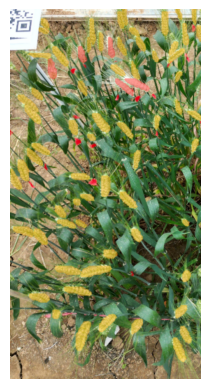

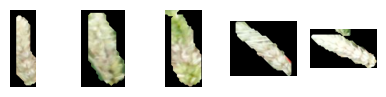

In [12]:
# Load the YOLOv8-WFD model
model = YOLO("Model_save/Yolov8-WFD.pt") 
# Path to the input image
image_path="Data/2.jpg"
# Extract FHB-related traits
_, _, _, _, _,roi_image_masks_WFD,results=trait_output_without_red_tags(image_path,model)
# Visualize results 
for r in results:
    im_array = r.plot(conf=0.5, labels=False, boxes=False)  
    predict_image = Image.fromarray(im_array[..., ::-1])  
    
    # Display the prediction result    
    plt.axis("off")
    plt.imshow(predict_image)

# Visualize extracted diseased spike regions (scab areas) in grid layout
plt_diseased_spikes(roi_image_masks_WFD)

